In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy
from functools import reduce

In [2]:
run_results = joblib.load("../results/run_2024-01-16_18:42:07_results.job")
run_model = joblib.load("../results/run_2024-01-16_18:42:07_model.job")

true_parameters = game.true_pars

number_of_samples = 500

iters = np.arange(0, 4000)

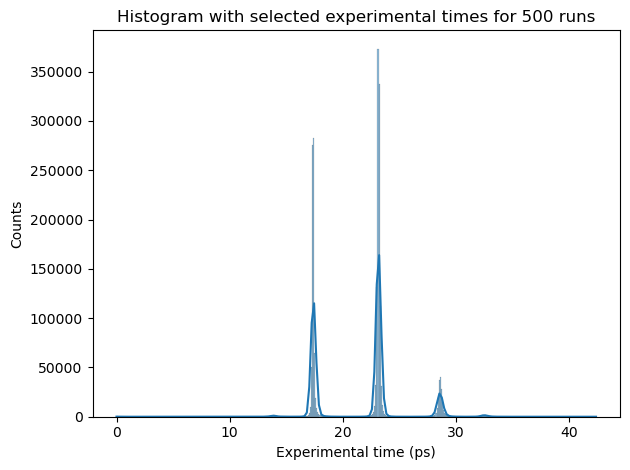

In [257]:
sns.histplot(np.array(run_results.times_array).flatten(), kde=True)
plt.title("Histogram with selected experimental times for 500 runs")
plt.xlabel("Experimental time (ps)")
plt.ylabel("Counts")
# plt.yscale('log')
plt.tight_layout()
plt.savefig('/tmp/img_code/hola.pdf', dpi=600)
plt.show()

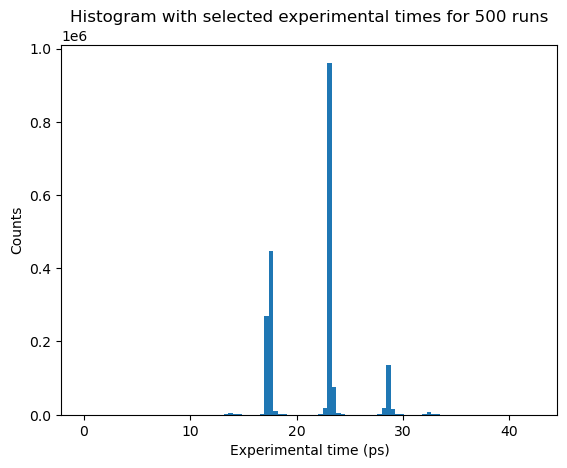

In [255]:
plt.hist(np.array(run_results.times_array).flatten(), bins=100)
plt.title("Histogram with selected experimental times for 500 runs")
plt.xlabel("Experimental time (ps)")
plt.ylabel("Counts")
# plt.yscale('log')
# plt.savefig('/tmp/img_code/hola.pdf', dpi=600)

In [3]:
def f_to_replace_with_nan(covariances, iteration):
    arr = np.array(covariances)
    arr[iteration + 1 :] = np.nan
    return arr

In [4]:
def return_cov_mse_per_step(results_run, true_parameters, number_of_samples):
    np_cov_arr = np.array(results_run.cov_array)
    np_estimates_arr = np.array(results_run.estimates_array)
    np_iter = np.array(results_run.iteration)

    for i in range(number_of_samples):
        np_cov_arr[i] = f_to_replace_with_nan(np_cov_arr[i], np_iter[i])
        np_estimates_arr[i] = f_to_replace_with_nan(
            np_estimates_arr[i], np_iter[i]
        )

    all_runs_diff_squared = (true_parameters - np_estimates_arr) ** 2

    mse_array_mean = np.nanmean(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )
    mse_array_median = np.nanmedian(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )

    mse_array_std = np.nanstd(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )

    cov_norm_array = jax.vmap(
        lambda a: vmap(jnp.linalg.norm, (0))(a), in_axes=(0)
    )(np_cov_arr)

    cov_norm_array_mean = np.nanmean(cov_norm_array, axis=0)
    cov_norm_array_median = np.nanmedian(cov_norm_array, axis=0)
    cov_norm_array_std = np.nanstd(cov_norm_array, axis=0)

    return [
        [
            cov_norm_array,
            [cov_norm_array_mean, cov_norm_array_median, cov_norm_array_std],
        ],
        [
            all_runs_diff_squared,
            [mse_array_mean, mse_array_median, mse_array_std],
        ],
    ]

In [5]:
[
    [
        cov_norm_array,
        [cov_norm_array_mean, cov_norm_array_median, cov_norm_array_std],
    ],
    [
        mse_array,
        [mse_array_mean, mse_array_median, mse_array_std],
    ],
] = return_cov_mse_per_step(run_results, true_parameters, 500)

In [6]:
np.nanmean(mse_array, axis=0).shape

(4000, 4)

In [7]:
variances_array = jax.vmap(lambda a: vmap(jnp.diag, (0))(a), in_axes=(0))(
    run_results.cov_array
)

variances_mean = np.nanmean(variances_array, axis=0)
variances_std = np.nanstd(variances_array, axis=0)


mse_indep_mean = np.nanmean(mse_array, axis=0)
mse_indep_std = np.nanstd(mse_array, axis=0)

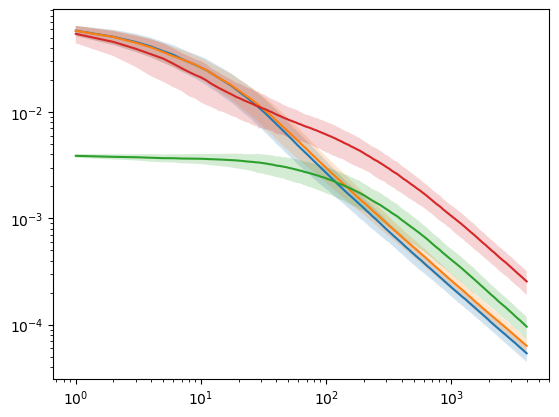

In [8]:
for i in range(4):
    plt.plot(iters[1:], variances_mean[1:, i])
    plt.fill_between(
        x=iters[1:],
        y1=variances_mean[1:, i] - variances_std[1:, i],
        y2=variances_mean[1:, i] + variances_std[1:, i],
        alpha=0.2,
    )

plt.yscale("log")
plt.xscale("log")

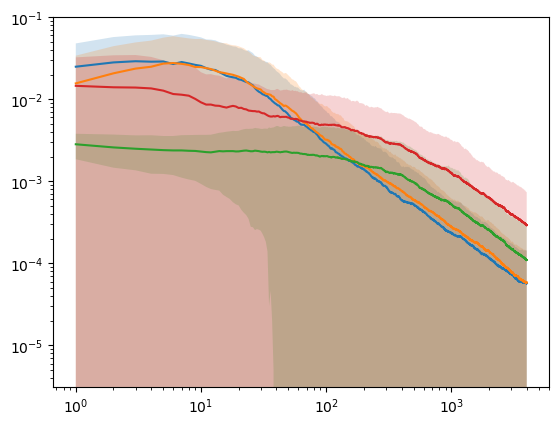

In [9]:
for i in range(4):
    plt.plot(iters[1:], mse_indep_mean[1:, i])
    plt.fill_between(
        x=iters[1:],
        y1=mse_indep_mean[1:, i] - mse_indep_std[1:, i],
        y2=mse_indep_mean[1:, i] + mse_indep_std[1:, i],
        alpha=0.2,
    )

plt.yscale("log")
plt.xscale("log")

In [10]:
names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

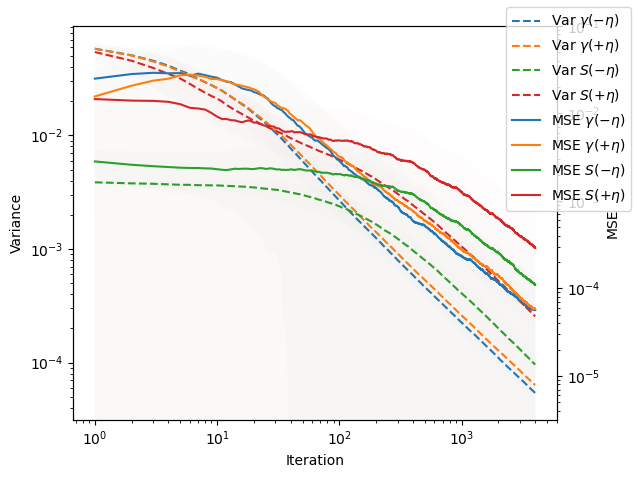

In [11]:
fig, ax1 = plt.subplots()

# color = 'tab:red'
ax1.set_xlabel("Iteration")
ax1.set_ylabel(
    "Variance",
)

for i in range(4):
    plt.plot(
        iters[1:], variances_mean[1:, i], ls="--", label="Var " + names_true[i]
    )
    plt.fill_between(
        x=iters[1:],
        y1=variances_mean[1:, i] - variances_std[1:, i],
        y2=variances_mean[1:, i] + variances_std[1:, i],
        alpha=0.01,
    )

ax1.tick_params(
    axis="y",
)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel(
    "MSE",
)  # we already handled the x-label with ax1
for i in range(4):
    plt.plot(iters[1:], mse_indep_mean[1:, i], label="MSE " + names_true[i])
    plt.fill_between(
        x=iters[1:],
        y1=mse_indep_mean[1:, i] - mse_indep_std[1:, i],
        y2=mse_indep_mean[1:, i] + mse_indep_std[1:, i],
        alpha=0.01,
    )

ax2.tick_params(
    axis="y",
)


ax1.set_xscale("log")
ax1.set_yscale("log")

ax2.set_xscale("log")
ax2.set_yscale("log")

fig.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [12]:
aux_df_list = []
for i in range(4):
    aux_df_list.append(
        pd.DataFrame(
            {
                "iteration": iters[1:],
                "Variance": variances_mean[1:, i],
                "MSE": mse_indep_mean[1:, i],
                "Parameter": names_true[i],
            }
        )
    )

In [13]:
aux_df_concat = pd.concat(aux_df_list)

In [14]:
dfm = aux_df_concat.melt(
    ["iteration", "Parameter"], var_name="Cols", value_name="vals"
)
dfm.head()

,iteration,Parameter,Cols,vals
0,1,$\gamma ( - \eta)$,Variance,0.058123
1,2,$\gamma ( - \eta)$,Variance,0.050831
2,3,$\gamma ( - \eta)$,Variance,0.045500
3,4,$\gamma ( - \eta)$,Variance,0.041194
4,5,$\gamma ( - \eta)$,Variance,0.037242


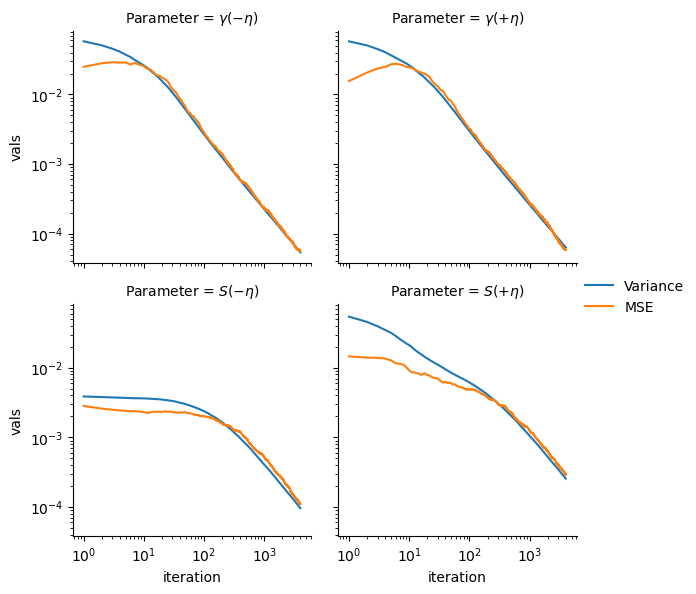

In [20]:
g = sns.FacetGrid(data=dfm, col="Parameter", col_wrap=2)
g.map_dataframe(
    sns.lineplot, x="iteration", y="vals", hue="Cols",estimator=None
)

g.add_legend()

plt.yscale("log")
plt.xscale("log")

In [ ]:
sns.pointplot(
    x="iteration",
    y="vals",
    hue="Cols",
    data=dfm,
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


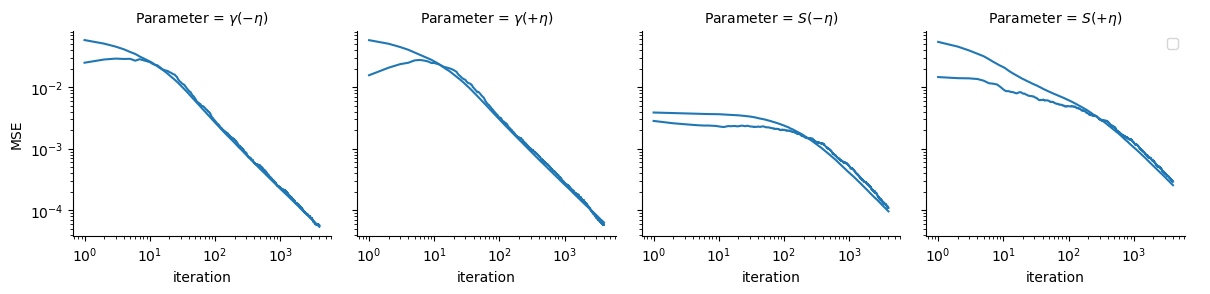

In [133]:
g = sns.FacetGrid(data=aux_df_concat, col="Parameter")
g.map_dataframe(sns.lineplot, x="iteration", y="Variance")
g.map_dataframe(sns.lineplot, x="iteration", y="MSE")

g.add_legend()

plt.yscale("log")
plt.xscale("log")
# plt.legend()
plt.show()

In [ ]:
sns.lineplot(
    data=aux_df_concat,
)

In [121]:
def fun_to_plot_axis(axis, m, n, parameter_to_plot):
    ax1 = axis[m, n]
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel(
        "Variance",
    )

    # for i in range(4):
    ax1.plot(
        iters[1:],
        variances_mean[1:, i],
        ls="--",
        label="Var " + names_true[parameter_to_plot],
    )
    ax1.fill_between(
        x=iters[1:],
        y1=variances_mean[1:, parameter_to_plot]
        - variances_std[1:, parameter_to_plot],
        y2=variances_mean[1:, parameter_to_plot]
        + variances_std[1:, parameter_to_plot],
        alpha=0.01,
    )

    ax1.tick_params(
        axis="y",
    )
    ax2 = ax1.twinx()
    ax2.set_ylabel(
        "MSE",
    )  # we already handled the x-label with ax1

    ax2.plot(
        iters[1:],
        mse_indep_mean[1:, i],
        label="MSE " + names_true[parameter_to_plot],
    )
    ax2.fill_between(
        x=iters[1:],
        y1=mse_indep_mean[1:, parameter_to_plot]
        - mse_indep_std[1:, parameter_to_plot],
        y2=mse_indep_mean[1:, parameter_to_plot]
        + mse_indep_std[1:, parameter_to_plot],
        alpha=0.01,
    )

    ax2.tick_params(
        axis="y",
    )
    ax1.set_xscale("log")
    ax1.set_yscale("log")

    ax2.set_xscale("log")
    ax2.set_yscale("log")

    ax1.legend()
    ax2.legend()

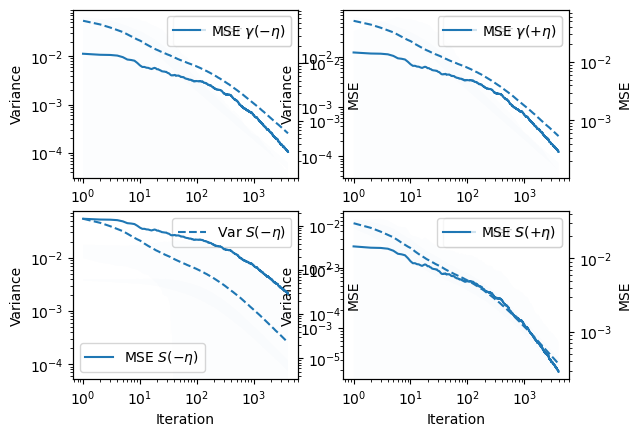

In [122]:
fig, axs = plt.subplots(2, 2)
fun_to_plot_axis(axs, 0, 0, 0)
fun_to_plot_axis(axs, 0, 1, 1)
fun_to_plot_axis(axs, 1, 0, 2)
fun_to_plot_axis(axs, 1, 1, 3)

# plt.legend()
plt.show()

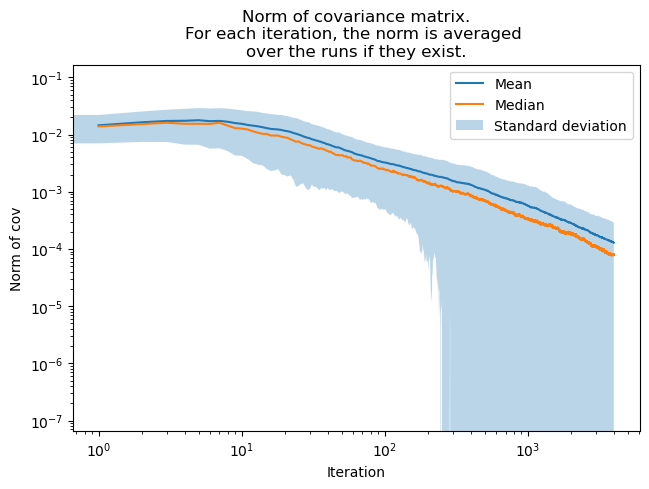

In [46]:
plt.plot(iters[1:], mse_array_mean[1:], label="Mean")
plt.plot(iters[1:], mse_array_median[1:], label="Median")
plt.fill_between(
    x=iters,
    y1=mse_array_mean - mse_array_std,
    y2=mse_array_mean + mse_array_std,
    alpha=0.3,
    label="Standard deviation",
)


# plt.plot(
#     iters[1:],
#     fun_to_fit(iters[1:], *fitting_estimates_cov),
#     label=f"Fitting {fitting_estimates_cov[0]:.4f}x^{fitting_estimates_cov[1]:.4f}",
# )


plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title(
    "Norm of covariance matrix.\nFor each iteration, the norm is averaged \nover the runs if they exist."
)
plt.tight_layout()
plt.xlabel("Iteration")
plt.ylabel("Norm of cov")


plt.show()

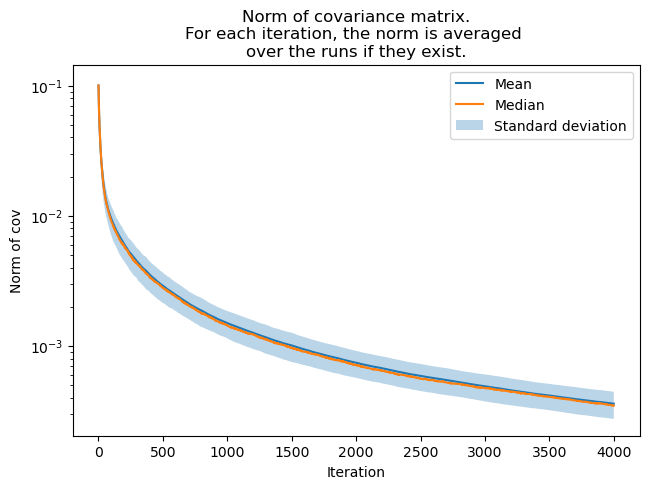

In [13]:
plt.plot(iters[1:], cov_norm_array_mean[1:], label="Mean")
plt.plot(iters[1:], cov_norm_array_median[1:], label="Median")
plt.fill_between(
    x=iters,
    y1=cov_norm_array_mean - cov_norm_array_std,
    y2=cov_norm_array_mean + cov_norm_array_std,
    alpha=0.3,
    label="Standard deviation",
)


# plt.plot(
#     iters[1:],
#     fun_to_fit(iters[1:], *fitting_estimates_cov),
#     label=f"Fitting {fitting_estimates_cov[0]:.4f}x^{fitting_estimates_cov[1]:.4f}",
# )


plt.yscale("log")
# plt.xscale("log")
plt.legend()
plt.title(
    "Norm of covariance matrix.\nFor each iteration, the norm is averaged \nover the runs if they exist."
)
plt.tight_layout()
plt.xlabel("Iteration")
plt.ylabel("Norm of cov")


plt.show()

In [ ]:
cumulative_times_per_run = (
    vmap(jnp.cumsum, in_axes=(0))(run_results.times_array) * 10
)[:, 1:]

all_time_df = [
    (
        lambda a, b, c: pd.DataFrame(
            {
                "time": a,
                "cov_norm": b,
                "mse": c,
            }
        ).iloc[1:]
    )(a, b, c)
    for (a, b, c) in zip(cumulative_times_per_run, cov_norm_array, mse_array)
]

In [37]:
aux_list = []
for i in range(500):
    for j in range(4):
        aux_list.append(
            pd.DataFrame(
                {
                    "Time": cumulative_times_per_run[i],
                    "Variance": variances_array[i, 1:, j],
                    "MSE":mse_array[i, 1:, j],
                    "Parameter": names_true[j],
                }
            )
        )

cumtimes_df_concat = pd.concat(aux_list)        

In [46]:
concat_df =pd.concat(aux_list, join="inner").sort_values(by="Time")
concat_df["Time"] = pd.to_timedelta(concat_df.Time, unit="ns")

In [48]:
concat_df

,Time,Variance,MSE,Parameter
0,0 days 00:00:00.000000092,0.053885,0.000079,$\gamma ( - \eta)$
0,0 days 00:00:00.000000092,0.065118,0.001258,$\gamma ( + \eta)$
0,0 days 00:00:00.000000092,0.003619,0.001337,$S ( - \eta)$
0,0 days 00:00:00.000000092,0.032799,0.007731,$S ( +\eta)$
0,0 days 00:00:00.000000094,0.066657,0.028327,$S ( +\eta)$
...,...,...,...,...
3998,0 days 00:00:00.001025163,0.000037,0.000041,$\gamma ( - \eta)$
3998,0 days 00:00:00.001025241,0.000110,0.000607,$S ( - \eta)$
3998,0 days 00:00:00.001025241,0.000042,0.000422,$\gamma ( - \eta)$
3998,0 days 00:00:00.001025241,0.000049,0.000050,$\gamma ( + \eta)$


In [57]:
mean_df = concat_df.groupby([concat_df.Time.dt.floor("1000ns"), concat_df.Parameter]).mean()
# mean_df = concat_df.groupby(concat_df.Time.dt.floor("1000ns")).mean()

# std_df = (
#     concat_df.groupby(concat_df.Time.dt.floor("1000ns"))
#     .std()
#     .cov_norm.to_numpy()
#     .astype("float")
# )

In [190]:
mean_df = concat_df.groupby(
    [concat_df.Time.dt.floor("1000ns"), concat_df.Parameter]
).agg({"Variance": "mean", "MSE": "mean"}).reset_index()

In [191]:
dfm = mean_df.melt(["Time", "Parameter"], var_name="Cols", value_name="vals")

dfm = dfm[
    (dfm.Time.dt.total_seconds() <= 7 * 1e5 / (1e9))
    & (dfm.Time.dt.total_seconds() > 0 / (1e9))
]

aggregated_time_dfm = (
    dfm[(dfm.Parameter == names_true[0]) & (dfm.Cols == "Variance")]
    .Time.to_numpy()
    .astype("float")
)

In [217]:
def aux_plot(*args, **kwargs):
    x = aggregated_time_dfm
    y1 = (lambda a: 500 / a)((aggregated_time_dfm))
    y2 = (lambda a: 10000 / a**2)((aggregated_time_dfm))

    plt.plot(
        x,
        y1,
        "--",
        label="SQL $ \\propto 1/ t$",
        alpha=0.7,
    )
    plt.plot(
        x,
        y2,
        "--",
        label="Heisenberg limit $ \\propto 1/ t^2$",
        alpha=0.7,
    )

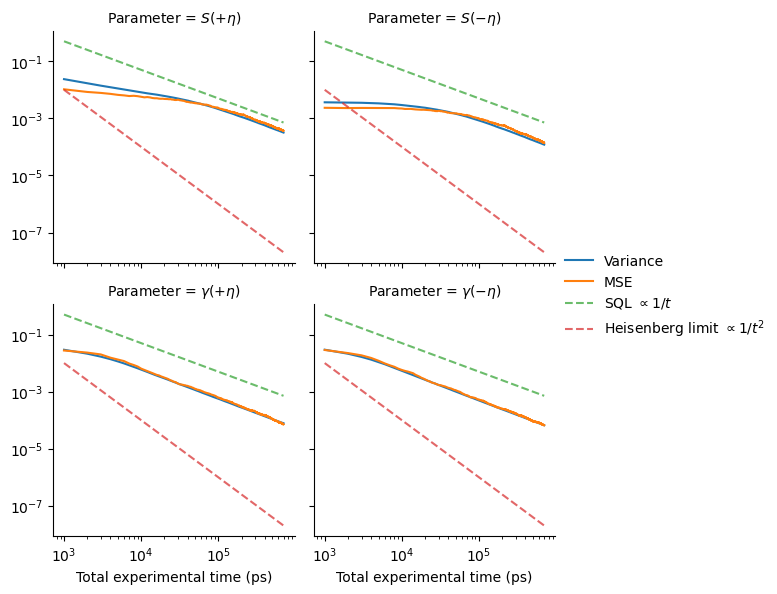

In [221]:

g = sns.FacetGrid(
    data=dfm,
    col="Parameter",
    col_wrap=2,
)
g.map_dataframe(sns.lineplot, x="Time", y="vals", hue="Cols", estimator=None)

g.map_dataframe(aux_plot)
g.add_legend()


# g.axes[0, 0].plot()

g.set_axis_labels("Total experimental time (ps)", y_var="")
plt.yscale("log")
plt.xscale("log")
# g.fig.suptitle("Scaling of MSE and Variance for each parameter")
plt.show()

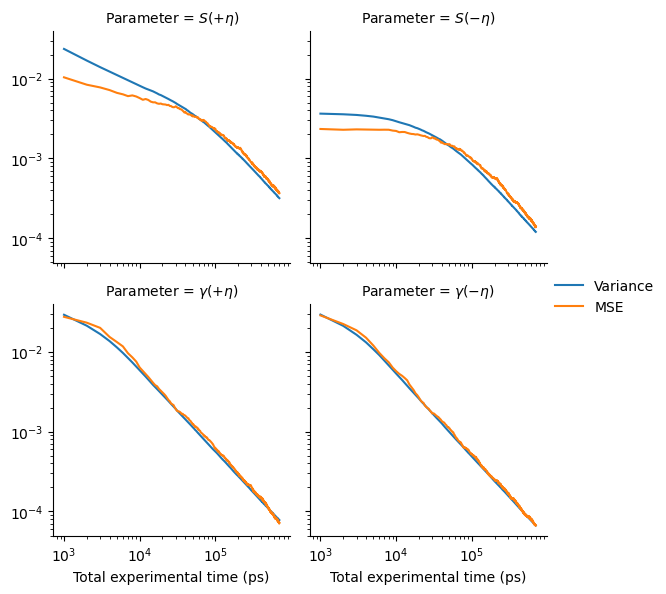

In [219]:

g = sns.FacetGrid(
    data=dfm,
    col="Parameter",
    col_wrap=2,
)
g.map_dataframe(sns.lineplot, x="Time", y="vals", hue="Cols", estimator=None)


g.add_legend()

# g.axes[0, 0].plot()

g.set_axis_labels("Total experimental time (ps)", y_var="")
plt.yscale("log")
plt.xscale("log")